In [2]:
## CORD-19 Data Analysis & Streamlit App

In [3]:
# Part 0: Install required packages
!pip install pandas matplotlib seaborn streamlit wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 61.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 107.7 MB/s eta 0:00:00


In [7]:
file_path = "metadata.csv"
# Install kagglehub with pandas-datasets support
!pip install kagglehub[pandas-datasets]

In [8]:
# Install kagglehub if not already installed
# !pip install kagglehub[pandas-datasets]

import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load the dataset from Kaggle ---
file_path = "metadata.csv"  # Specify the file in the dataset

df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "allen-institute-for-ai/CORD-19-research-challenge",
    file_path
)

# --- Basic Exploration ---

# 1. Shape of the dataset
print("Shape of dataset:", df.shape)

# 2. Column data types
print("\nColumn data types:")
print(df.dtypes)

# 3. Preview first few rows
print("\nFirst 5 records:")
print(df.head())

# 4. Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# 5. Basic statistics for numeric columns
print("\nNumeric statistics:")
print(df.describe())

/tmp/ipython-input-2959648813.py:13: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


100%|██████████| 560M/560M [00:03<00:00, 173MB/s]

Extracting zip of metadata.csv...



/usr/local/lib/python3.12/dist-packages/kagglehub/pandas_datasets.py:91: DtypeWarning: Columns (1,4,5,6,13,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  result = read_function(


Shape of dataset: (1056660, 19)

Column data types:
cord_uid             object
sha                  object
source_x             object
title                object
doi                  object
pmcid                object
pubmed_id            object
license              object
abstract             object
publish_time         object
authors              object
journal              object
mag_id              float64
who_covidence_id     object
arxiv_id             object
pdf_json_files       object
pmc_json_files       object
url                  object
s2_id               float64
dtype: object

First 5 records:
   cord_uid                                       sha source_x  \
0  ug7v899j  d1aafb70c066a2068b02786f8929fd9c900897fb      PMC   
1  02tnwd4m  6b0567729c2143a66d737eb0a2f63f2dce2e5a7d      PMC   
2  ejv2xln0  06ced00a5fc04215949aa72528f2eeaae1d58927      PMC   
3  2b73a28n  348055649b6b8cf2b9a376498df9bf41f7123605      PMC   
4  9785vg6d  5f48792a5fa08bed9f56016f4981ae2ca6031b32 

In [10]:
# Part 2: Data Cleaning & Preparation

# Convert publication date to datetime
df['publish_time'] = pd.to_datetime(df['publish_time'], errors='coerce')

# Extract year from publication date
df['year'] = df['publish_time'].dt.year

# Drop rows without titles or abstracts and make a copy
df_clean = df.dropna(subset=['title', 'abstract']).copy()

# Fill missing values safely
df_clean['journal'] = df_clean['journal'].fillna('Unknown')
df_clean['source_x'] = df_clean['source_x'].fillna('Unknown')

# Create a new column: abstract word count
df_clean['abstract_word_count'] = df_clean['abstract'].apply(lambda x: len(str(x).split()))

# Preview cleaned data
df_clean.head()


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,...,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id,year,abstract_word_count
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,...,BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN,2001.0,262
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,...,Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN,2000.0,142
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,...,Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN,2000.0,219
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,...,Respir Res,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN,2001.0,68
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,...,Respir Res,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN,2001.0,110


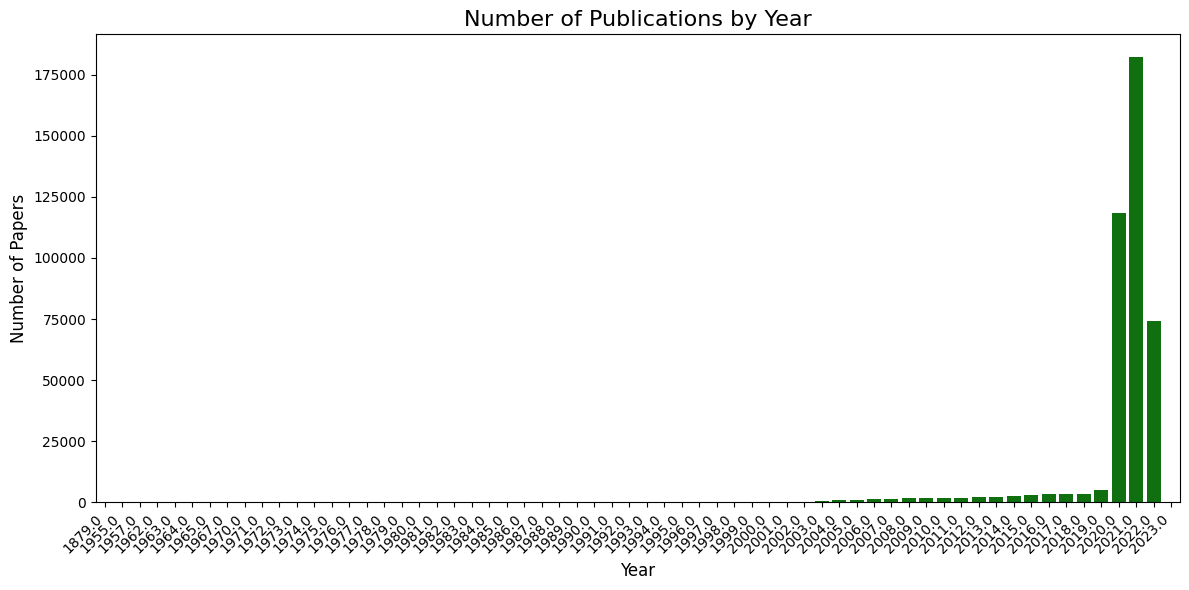

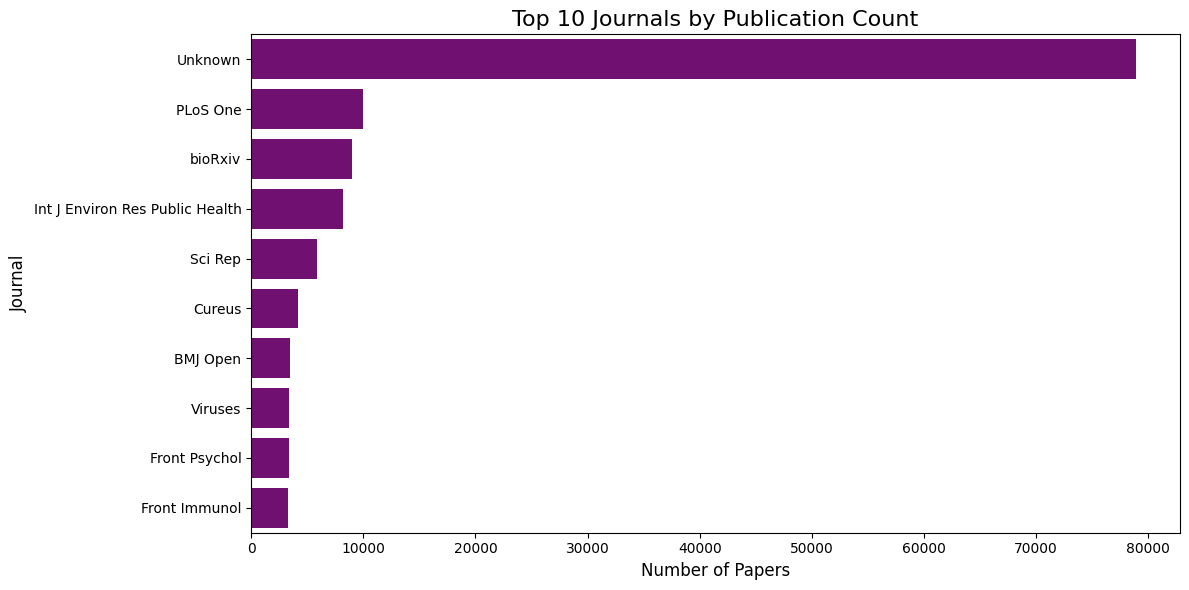

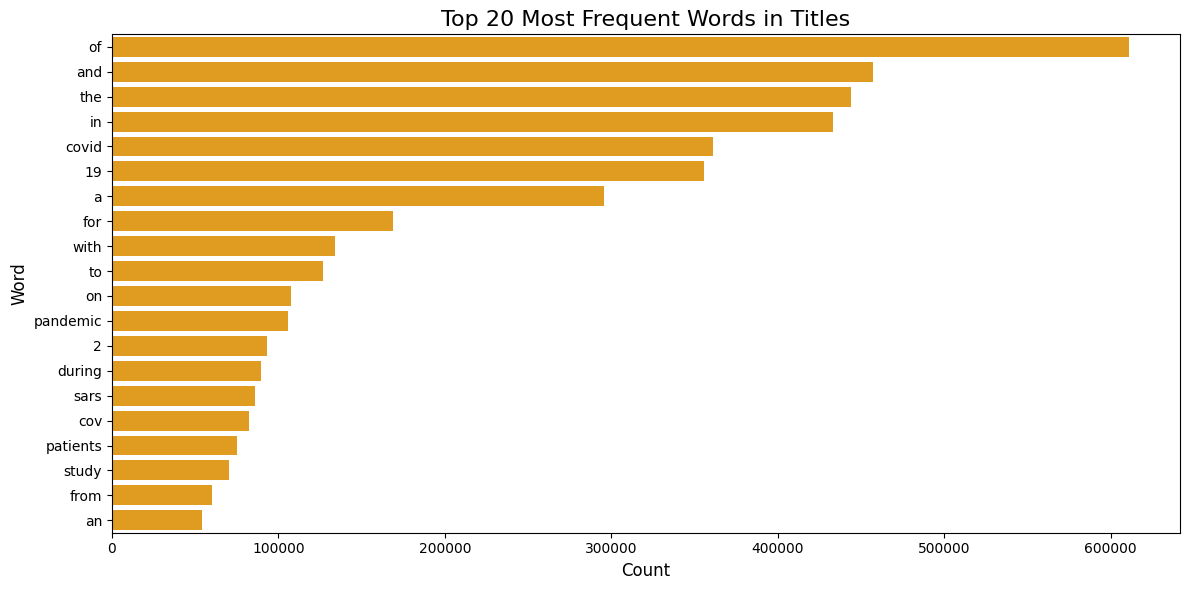

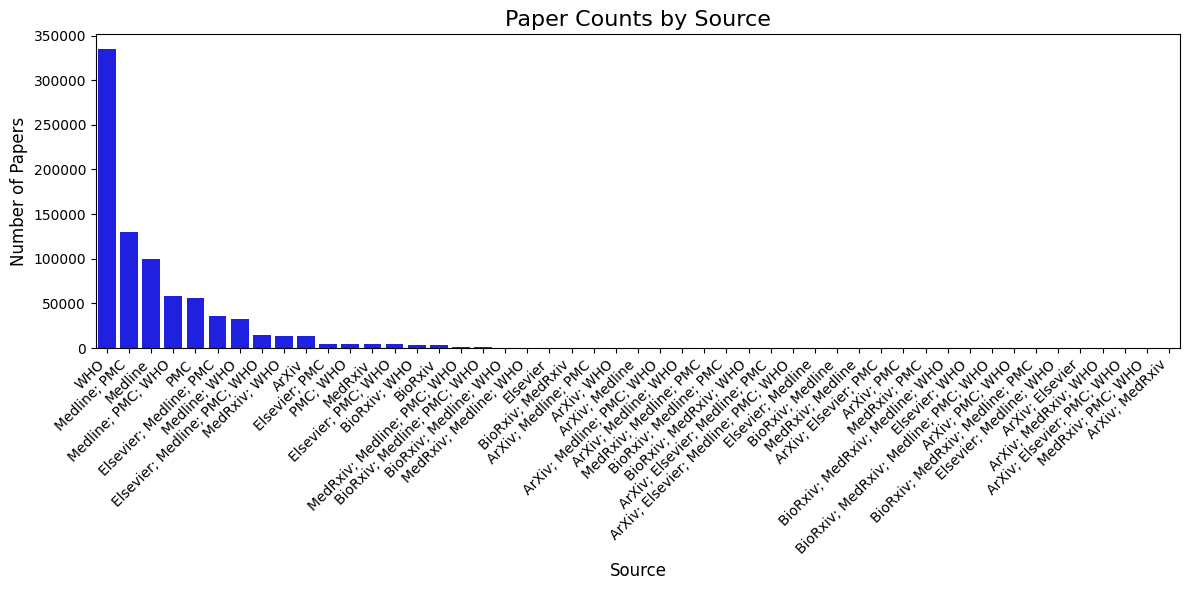

In [14]:
# Part 3: Analysis & Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re

# 1. Publications by Year
year_counts = df_clean['year'].value_counts().sort_index()

plt.figure(figsize=(12,6))
sns.barplot(x=year_counts.index, y=year_counts.values, color='green')
plt.title('Number of Publications by Year', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Papers', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# --- 2. Top 10 Journals ---
top_journals = df_clean['journal'].value_counts().head(10)

plt.figure(figsize=(12,6))
sns.barplot(x=top_journals.values, y=top_journals.index, color='purple')
plt.title('Top 10 Journals by Publication Count', fontsize=16)
plt.xlabel('Number of Papers', fontsize=12)
plt.ylabel('Journal', fontsize=12)
plt.tight_layout()
plt.show()

# 3. Most Frequent Words in Titles
all_titles = " ".join(df_clean['title'].astype(str).dropna()).lower()
words = re.findall(r'\b\w+\b', all_titles)
common_words = Counter(words).most_common(20)

words_list, counts = zip(*common_words)

plt.figure(figsize=(12,6))
sns.barplot(x=list(counts), y=list(words_list), color='orange')
plt.title('Top 20 Most Frequent Words in Titles', fontsize=16)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Word', fontsize=12)
plt.tight_layout()
plt.show()

# 4. Distribution by Source
source_counts = df_clean['source_x'].value_counts()

plt.figure(figsize=(12,6))
sns.barplot(x=source_counts.index, y=source_counts.values, color='blue')
plt.title('Paper Counts by Source', fontsize=16)
plt.xlabel('Source', fontsize=12)
plt.ylabel('Number of Papers', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()